# Análise Exploratória de Dados dos passageiros do Titanic

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1 - Importando e compreendendo

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Explicando as variáveis:

* PassengerID: Um ID do passageiro
* Survived: Se sobreviveu ou não ao desastre (1 - Sobreviveu, 0 - Não sobreviveu)
* Pclass: Classe da passagem (1a, 2a ou 3a)
* Name: Nome do passageiro
* Sex: Sexo do passageiro
* Age: Idade
* SibSp: Para crianças, número de irmãos abordo do navio. Para adultos, número de cônjuges abordo do navio
* Parch: Para crianças, número de pais abordo do navio. Para adultos, número de filhos abordo do navio.
* Ticket: Número do ticket
* Fare: tarifa do ticket
* Cabin: Número da cabine
* Embarked: Porto de embarque

Vamos trabalhar apenas com as variáveis **Passenger ID, Survived, Pclass, Sex, Age, SibSp, Parch**

In [4]:
df = df[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']].set_index('PassengerId')

In [5]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
PassengerId,,,,,,
1,0,3,male,22.0,1,0
2,1,1,female,38.0,1,0
3,1,3,female,26.0,0,0
4,1,1,female,35.0,1,0
5,0,3,male,35.0,0,0


## 2 - Tratando dados ausentes

In [6]:
df.count()

Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
dtype: int64

Pode-se observar que em algumas instâncias há idades faltantes.
Há duas possibilidades:

1. Excluir instâncias cuja idade está faltando  
2. Tentar aproveitar essas instâncias preenchendo a idade com um valor coerente

Seguirei com a segunda estratégia.

Poderia simplesmente substituir a idade faltante das mulheres com a média da idade de todas as mulheres, e fazer o mesmo raciocínio para os homens. Porém acredito que é possível fazer melhor que isso. Usarei todas as variáveis para fazer o input das idades. 

É preciso notar que **Survived, Pclass e Sex** são categóricas, porém **SibSp e Parch** não são, logo precisamos caregorizá-las separando-as em buckets.

Observe que se **SibSp** > 1, há um forte indicativo de que o indivíduo é uma criança, pois um adulto não pode ter mais de um cônjugue. Logo, separarei **SibSp** nas seguintes categorias: (0, 1, >1)

Se **Parch** > 2, há um forte indicativo de que o indivíduo é um adulto, pois uma criança não pode ter mais de 2 pais. Separarei **Parch** em: (0, 1-2, >2)


In [7]:
df['SibSp_cat'] = df['SibSp'].apply(lambda x: str(x) if x <= 1 else '>1').astype('category')

def parch_cat(dt):
    if dt == 1 or dt == 2:
        return '1-2'
    elif dt > 2:
        return '>2'
    return str(dt)

df['Parch_cat'] = df['Parch'].apply(parch_cat).astype('category')

Vamos agora inputar as idades com a média de cada grupo

In [8]:
def preencher(dt):
    dt['Age'] = dt['Age'].fillna(dt['Age'].mean())
    return dt

df2 = df.groupby(['Survived', 'Pclass', 'Sex', 'SibSp_cat', 'Parch_cat'], group_keys=False).apply(preencher)

In [9]:
df2.count()

Survived     891
Pclass       891
Sex          891
Age          890
SibSp        891
Parch        891
SibSp_cat    891
Parch_cat    891
dtype: int64

Após o processo, ainda há uma instância com dados faltando

In [10]:
df2[df2.Age.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,SibSp_cat,Parch_cat
PassengerId,,,,,,,,
302,1,3,male,NaN,2,0,>1,0


Pelos motivos explicados mais em cima, essa instância corresponde a uma criança, porém como **Parch** é 0 ela não estava viajando com os pais. Provavelmente estava viajando com uma babá, ou um dos seus dois irmãos era responsável pelo garoto. Como esse caso é raro, não tínhamos dados similares para estimar a idade do garoto na etapa anterior. 

Vou estimá-la com a média da idade de homens abaixo de 14 anos da 3a classe que sobreviveram

In [11]:
df2.loc[302, 'Age'] = int(df2['Age'][(df2.Sex == 'male') & (df2.Survived==1) & (df2.Age <= 14) & (df2.Pclass==3)].mean())

Com os dados ausentes tratados, podemos prosseguir para a análise

## 3 - Análise

O foco principal da análise será como as variáveis afetam a probabilidade de sobrevivência. Para começar, vamos fazer uma análise univariada para compreender melhor a base de dados.

Text(0, 0.5, '')

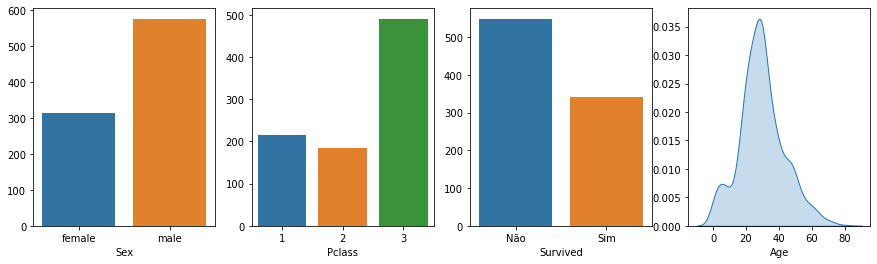

In [12]:
fig = plt.figure(figsize=(15,4))
axe = fig.subplots(1,4)
_ = df2.groupby('Sex',group_keys=False).size().reset_index()
sns.barplot(x='Sex', y=0, ax=axe[0],data=_)
axe[0].set_ylabel('')
_ = df2.groupby('Pclass',group_keys=False).size().reset_index()
sns.barplot(x='Pclass', y=0, ax=axe[1],data=_)
axe[1].set_ylabel('')

_ = df2.groupby('Pclass',group_keys=False).size().reset_index()
sns.barplot(x='Pclass', y=0, ax=axe[1],data=_)
axe[1].set_ylabel('')

_ = df2.groupby('Survived',group_keys=False).size().reset_index()
sns.barplot(x='Survived', y=0, ax=axe[2],data=_)
axe[2].set_ylabel('')
axe[2].set_xticklabels(['Não', 'Sim'])

sns.kdeplot(x='Age', ax=axe[3],data=df2, fill=True)
axe[3].set_ylabel('')

Vamos tornar a variável **Age** em categórica para facilitar a análise. As classes serão divididas de forma que contenham o mesmo número de indivíduos.

In [13]:
df2['Age_cat'] = pd.qcut(df2['Age'], 4, precision=0)

Para analisar o efeito de uma variável na probabilidade de sobrevivência precisamos manter as outras variáveis constantes e variar apenas a variável de interesse.

### 3.1 - Como o  sexo do indivíduo e a classe da passagem influenciam na probabilidade de sobrevivência?

Não podemos simplesmente observar qual sexo tem a maior porcentagem de sobreviventes, pois outras variáveis podem estar interferindo. Ao analisar apenas a variável **Sex** não sabemos quanto da diferença na probabilidade de sobrevivência se deve às outras variáveis.

Como as variáveis são categóricas, para capturar o real efeito da variável **Sex**, precisamos analisar dentro de grupos em que as outras variáveis permanecem constante.

In [14]:
df3 = df2.groupby(['Pclass', 'Age_cat', 'Sex'], as_index=False)['Survived'].mean()
df3['Survived'] = df3['Survived']*100

In [15]:
df3.head()

,Pclass,Age_cat,Sex,Survived
0,1,"(-1.0, 22.0]",female,93.750000
1,1,"(-1.0, 22.0]",male,50.000000
2,1,"(22.0, 29.0]",female,92.857143
3,1,"(22.0, 29.0]",male,52.941176
4,1,"(29.0, 37.0]",female,100.000000


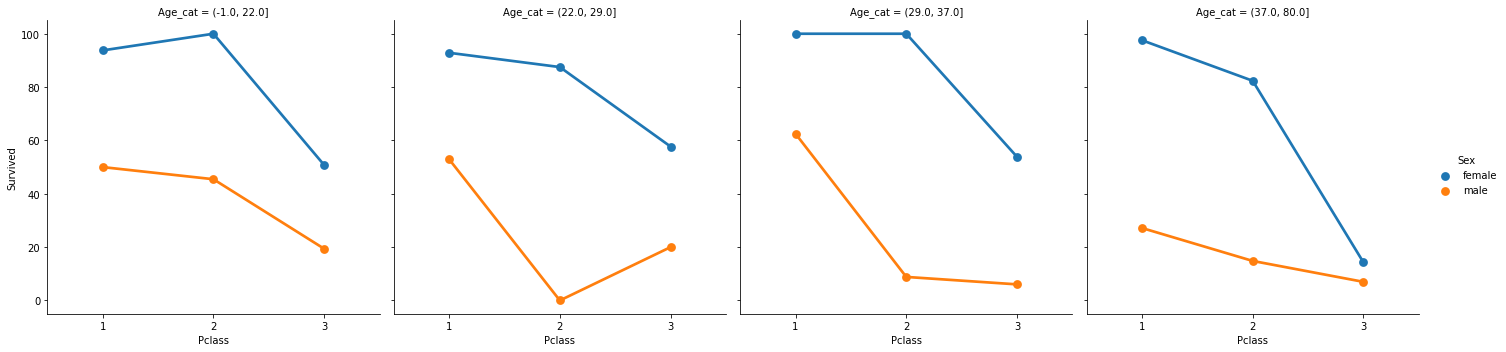

In [16]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', col='Age_cat', kind='point',data=df3)

#### Descobertas:

* Pode-se observar que em todos os casos mulheres têm uma maior chance de sobrevivência do que homens. Esse resultado é esperado, afinal é sabido que mulheres e crianças têm prioridade de resgate em casos de emergência.

* A porcentagem de sobreviventes em geral cai nas classes mais populares. A classe é uma variável proxy para a condição econômica, ou seja, indivíduos da primeira classe provavelmente são os mais ricos da embarcação e os da terceira classe os mais pobres do navio.


### 3.2 - Como a idade do indivíduo influencia na probabilidade de sobrevivência?

Utilizando o mesmo data frame do item anterior e apenas alterando o eixo.

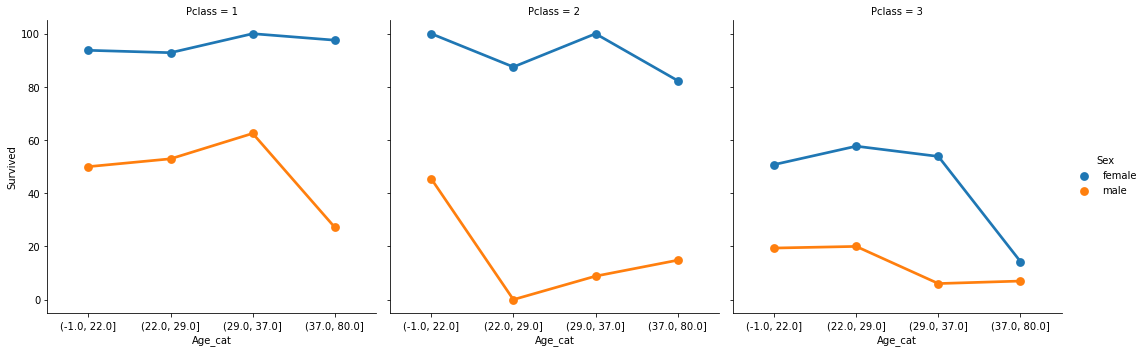

In [17]:
sns.catplot(x='Age_cat', y='Survived', hue='Sex', col='Pclass',kind='point', data=df3)

Com esse gráfico não está muito claro o efeito da idade, talvez pelo fato de a idade ter sido categorizada. Vamos tentar analisá-la como uma variável contínua utilizando um boxplot.

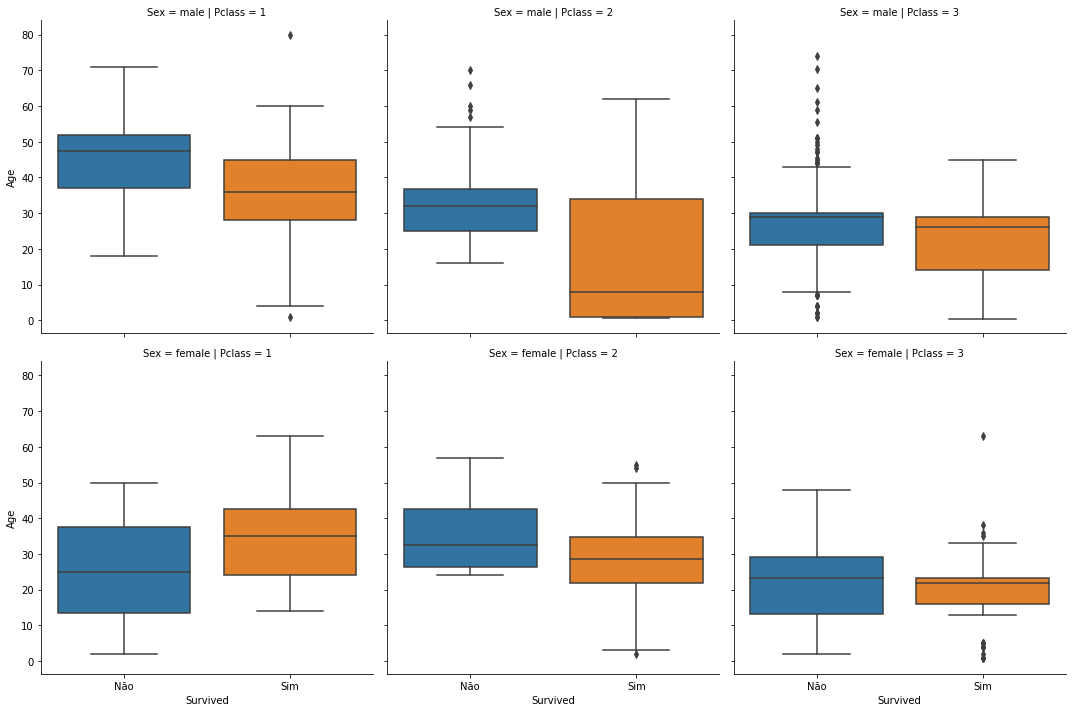

In [18]:
df_t = df2.copy()
df_t['Survived'] = df_t['Survived'].apply(lambda x: ['Não', 'Sim'][x])
sns.catplot(x='Survived', y='Age', col='Pclass', row='Sex',kind='box', data=df_t)

A idade mediana dos sobreviventes é  em geral menor, porém no grupo das mulheres da primeira classe há uma quebra desse padrão. Vamos investigar isso melhor, checando o número de indivíduos em cada grupo.

In [19]:
df2.groupby(['Pclass', 'Sex', 'Survived']).size()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
dtype: int64

Observe que nas classes 1 e 2, o número de mulheres que não sobreviveram é muito pequeno (3 e 6 respectivamente). Como a amostra é muito pequena, fica difícil tirar conclusões sobre a distribuição de idade nesses grupos. Por isso, vou escolher grupos em que há indivíduos suficientes que sobreviveram e não sobreviveram para observar o efeito da idade.

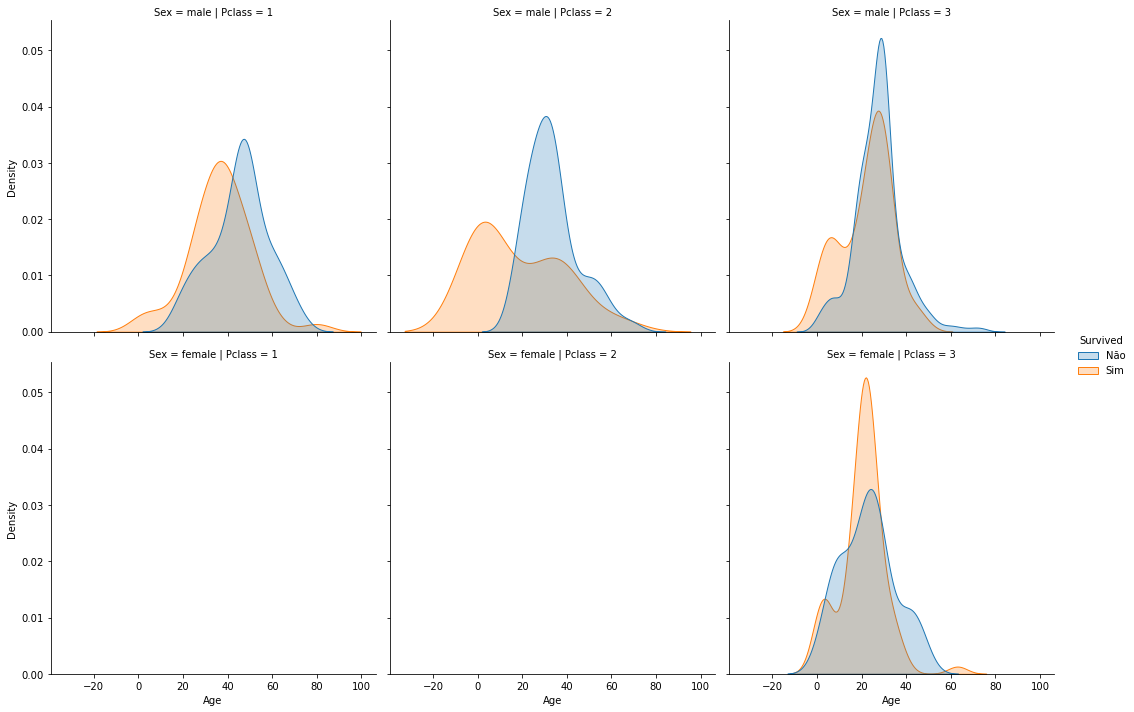

In [20]:
df_t = df2[np.logical_not((df['Sex'] == 'female') & np.isin(df2['Pclass'], [1,2]))].copy()
df_t['Survived'] = df_t['Survived'].apply(lambda x: ['Não', 'Sim'][x])
sns.displot(x='Age', hue='Survived', col='Pclass',row='Sex',kind='kde',data=df_t, common_norm=False, fill=True)

#### Descobertas:
* Nos grupos de sobreviventes parece haver uma concentração maior de pessoas mais novas. É possível observar nesse grupo uma crista próxima do 0, indicando uma concentração de crianças.

### 3.3 - Como a quantidade de parentes a bordo influencia na probabilidade de sobrevivência?

####  - Adultos
Para os adultos **Parch** representa o número de filhos a bordo do navio. Já **SibSp** representa o número de parceiros a bordo.

Criarei a variável **Child** (indicando se o indivíduo tem pelo menos um filho a bordo) e **Partner** (indicando se possui um cônjugue a bordo).

In [21]:
df_ad = df2[df2['Age'] > 21].copy()

In [22]:
df_ad['Child'] = df_ad['Parch'] > 0
df_ad['Partner'] = df_ad['SibSp'] > 0

Vou selecionar apenas a 3a classe, pois é  a mais populosa.

In [23]:
df_ad3 = df_ad[df_ad['Pclass'] == 3].copy()

In [24]:
df_ad3.groupby(['Sex', 'Child', 'Partner'])['Survived'].agg([('Sobreviveram',lambda x: np.round(100*np.mean(x),2)), 
                                                             ('Tamanho',np.size)])

Sobreviveram  Tamanho
Sex    Child Partner                       
female False False           61.36       44
             True            58.82       17
       True  False           41.67       12
             True            25.00       12
male   False False           12.74      212
             True             3.85       26
       True  False            0.00        3
             True             0.00        8

* Analisando a proporção de sobreviventes, para ambos os sexos a presença de filhos ou de um parceiro parece diminuir a probabilidade de sobrevivência. É complicado assumir isso como verdade, pois o tamanho das amostras são muito pequenas em alguns casos.

####  - Crianças
Para as crianças **Parch** representa o número de pais a bordo do navio. Já **SibSp** representa o número de irmãos a bordo.

Criarei a variável **Parents** (indicando se o indivíduo tem pelo menos um pai a bordo) e **Siblings** (indicando se possui pelo menos um irmão a bordo).

In [25]:
df_chil = df2[df2['Age'] < 18].copy()

In [26]:
df_chil['Parents'] = df_chil['Parch'] > 0
df_chil['Siblings'] = df_chil['SibSp'] > 0

Vou selecionar novamente apenas a 3a classe, pois é  a mais populosa.

In [27]:
df_chil3 = df_chil[df_chil['Pclass'] == 3].copy()

In [28]:
df_chil3.groupby(['Sex', 'Parents', 'Siblings'])['Survived'].agg([('Sobreviveram',lambda x: np.round(100*np.mean(x),2)), 
                                                                  ('Tamanho',np.size)])

Sobreviveram  Tamanho
Sex    Parents Siblings                       
female False   False            75.00        8
               True             66.67        3
       True    False            71.43        7
               True             32.00       25
male   False   False            10.00       10
               True             50.00        4
       True    False           100.00        3
               True             20.59       34

As amostras de cada categoria são muito pequenas para tirar conclusões. Vou adotar outro caminho, analisarei a distribuição da quantidade de irmãos entre as crianças sobreviventes e as não sobreviventes.

In [29]:
df_t = df_chil3[df_chil3['Parents'] & df_chil3['Siblings']]

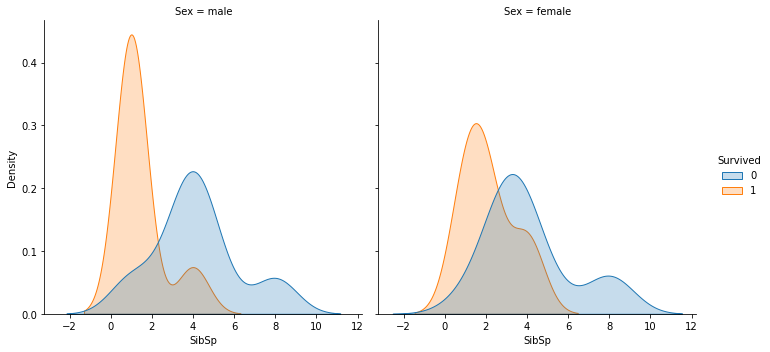

In [30]:
sns.displot(x='SibSp', hue='Survived',col='Sex',kind='kde',common_norm=False, fill=True, data=df_t)

* Analisando as distribuições é possível observar que as crianças sobreviventes têm menos irmãos.

## 4 - Resumo da análise

* Mulheres têm maior chance de sobrevivência do que homens, provavelmente por causa do protocolo de priorizar mulheres e crianças no caso de um desastre.
* Quanto melhor a classe da passagem maior a probabilidade de sobrevivência, provavelmente pelo fato de melhores classes possuirem pessoas mais ricas.
* O efeito da idade não está muito claro, porém parece que indivíduos mais novos têm maior chance de sobrevivência, principalmente as crianças.
* A presença de filhos ou de um cônjugue a bordo parece diminuir a probabilidade de sobrevivência, porém a amostra é muito pequena para afirmar esse efeito com certeza. 
* Para as crianças, a presença de irmãos parece diminuir a probabilidade de sobrevivência, porém a amostra também é muito pequena para uma conclusão definitiva.